In [ ]:
!pip install wandb -q

In [ ]:
import wandb

In [ ]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
wandb.init(project="rehospitalization")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, recall_score, f1_score

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Medical Predictions/data/diabetic_data.csv')

# Data for these columns are stored as IDs. We will probably need to map these IDs to their actual values.
admission_mapping = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Medical Predictions/data/admission_id_mappings.csv')
admission_source_mapping = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Medical Predictions/data/admission_source_id_mappings.csv')
discharge_mapping = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Medical Predictions/data/discharge_id_mappings.csv')

In [ ]:
data["readmitted_within_30_days"] = data["readmitted"].map({
    "NO": 0,
    "<30": 1,
    ">30": 0
})
data.drop("readmitted", axis=1, inplace=True)

Data is obviously imbalanced, we need to handle with the problem

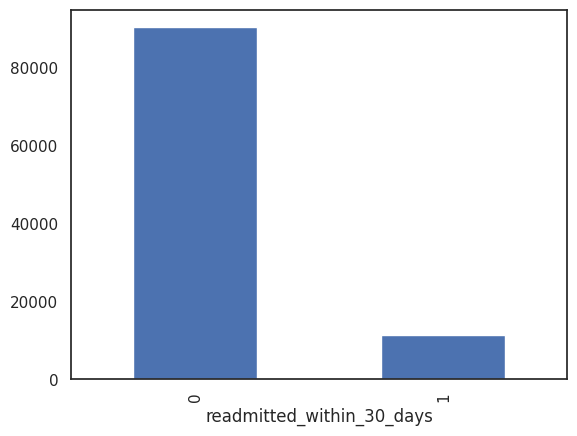

,count
readmitted_within_30_days,
0,90409
1,11357


In [ ]:
data['readmitted_within_30_days'].value_counts().plot(kind='bar')
plt.show()

data['readmitted_within_30_days'].value_counts()

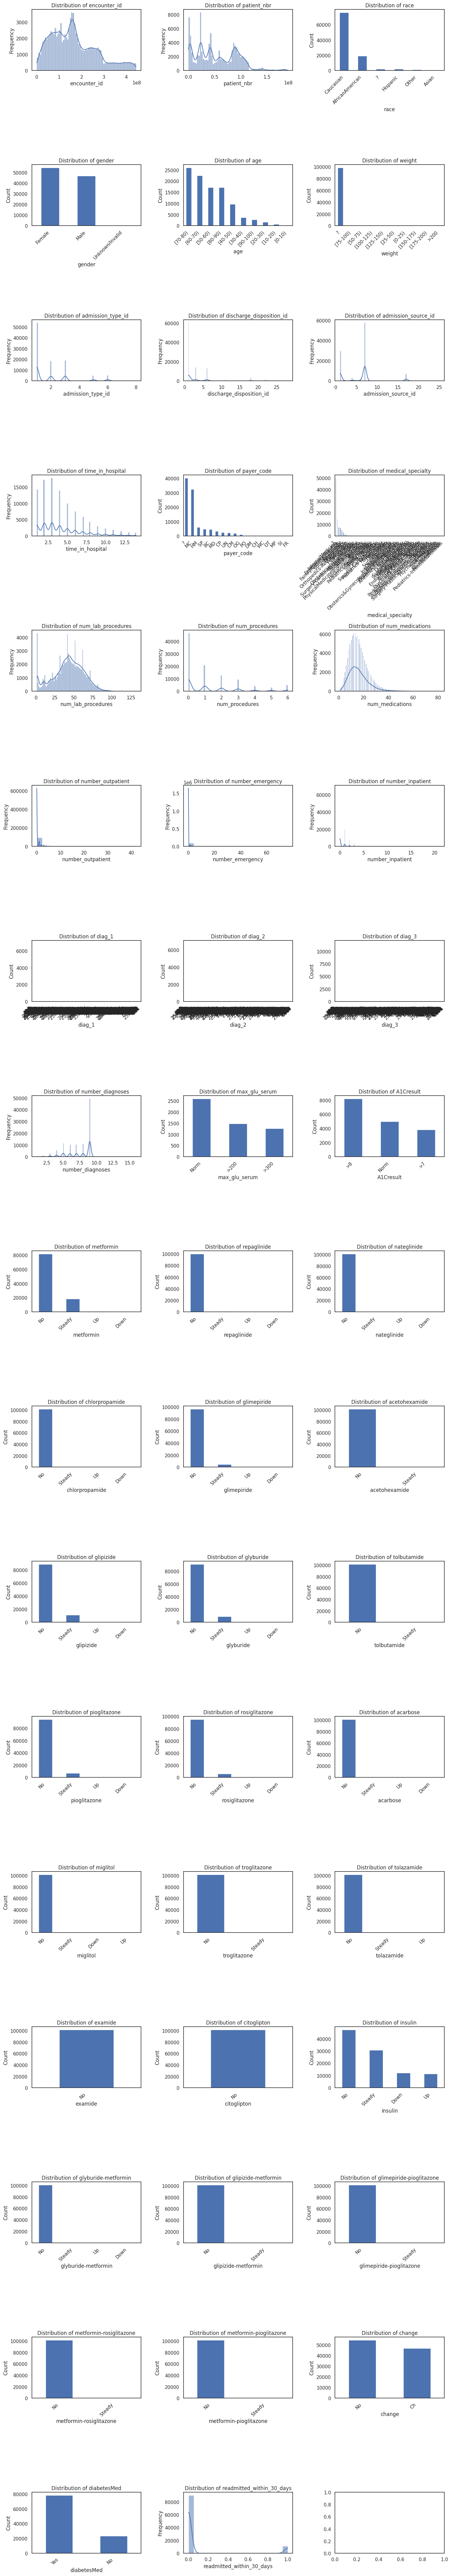

In [ ]:

num_columns = 3
num_rows = (len(data.columns) + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 5, num_rows * 5))
axes = axes.flatten()

for i, column in enumerate(data.columns):
    ax = axes[i]

    if data[column].dtype == 'object':
        data[column].value_counts().plot(kind='bar', ax=ax)
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Count')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    else:
        sns.histplot(data[column], kde=True, ax=ax)
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
data.drop("encounter_id", axis=1, inplace=True)

In [ ]:
most_frequent_race = data['race'].mode()[0]
data['race'] = data['race'].replace('?', most_frequent_race)

race_dummies = pd.get_dummies(data['race'], prefix='race')
data = pd.concat([data, race_dummies], axis=1)
data.drop('race', axis=1, inplace=True)

In [ ]:
gender_dummies = pd.get_dummies(data['gender'], prefix='gender')
data = pd.concat([data, gender_dummies], axis=1)
data.drop('gender', axis=1, inplace=True)

In [ ]:
le = LabelEncoder()
data['age'] = le.fit_transform(data['age'])

In [ ]:
# Weight column is very sparce so I decide to discard it completely
data.drop('weight', axis=1, inplace=True)

In [ ]:
data.drop('payer_code', axis=1, inplace=True)

In [ ]:
data.drop('medical_specialty', axis=1, inplace=True)

In [ ]:
max_glu_serum_dummies = pd.get_dummies(data['max_glu_serum'], prefix='max_glu_serum')
data = pd.concat([data, max_glu_serum_dummies], axis=1)
data.drop('max_glu_serum', axis=1, inplace=True)

In [ ]:
A1Cresult_dummies = pd.get_dummies(data['A1Cresult'], prefix='A1Cresult')
data = pd.concat([data, A1Cresult_dummies], axis=1)
data.drop('A1Cresult', axis=1, inplace=True)

In [ ]:
columns_to_encode = ['metformin', 'repaglinide', 'nateglinide', 'glimepiride',
                     'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin']
data = pd.get_dummies(data, columns=columns_to_encode, prefix=columns_to_encode, drop_first=True)

columns_to_delete = ['chlorpropamide', 'acetohexamide', 'glipizide', 'tolbutamide',
                     'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'glyburide-metformin',
                     'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

data = data.drop(columns=columns_to_delete)

In [ ]:
change_dummies = pd.get_dummies(data['change'], prefix='change', drop_first=True)
data = pd.concat([data, change_dummies], axis=1)
data.drop('change', axis=1, inplace=True)

In [ ]:
diabetesMed_dummies = pd.get_dummies(data['diabetesMed'], prefix='diabetesMed', drop_first=True)
data = pd.concat([data, diabetesMed_dummies], axis=1)
data.drop('diabetesMed', axis=1, inplace=True)

In [ ]:
for col in ['diag_1', 'diag_2', 'diag_3']:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col] = data[col].fillna(0)

In [ ]:
data.describe()

,patient_nbr,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,readmitted_within_30_days
count,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,5.433040e+07,6.096702,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,485.502676,426.199940,391.547405,7.422607,0.111599
std,3.869636e+07,1.594084,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,214.370614,190.820558,199.672261,1.933600,0.314874
min,1.350000e+02,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.341322e+07,5.000000,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,404.000000,276.000000,250.410000,6.000000,0.000000
50%,4.550514e+07,6.000000,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,435.000000,424.000000,401.000000,8.000000,0.000000
75%,8.754595e+07,7.000000,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,594.000000,518.000000,493.750000,9.000000,0.000000
max,1.895026e+08,9.000000,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,999.000000,999.000000,999.000000,16.000000,1.000000


In [ ]:
X = data.drop('readmitted_within_30_days', axis=1)
y = data['readmitted_within_30_days']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
columns_to_normalize = ['age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient']

scaler = MinMaxScaler()
X_train[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])
X_test[columns_to_normalize] = scaler.transform(X_test[columns_to_normalize])

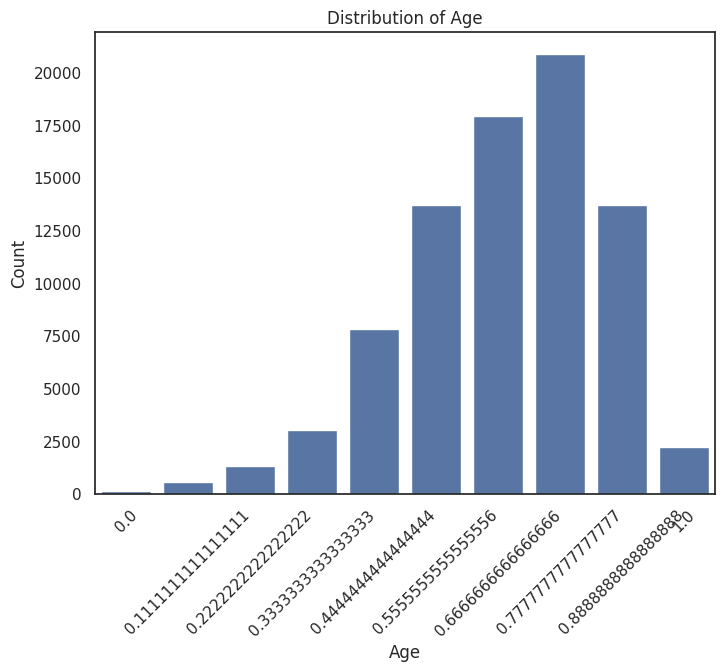

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='age', data=X_train)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

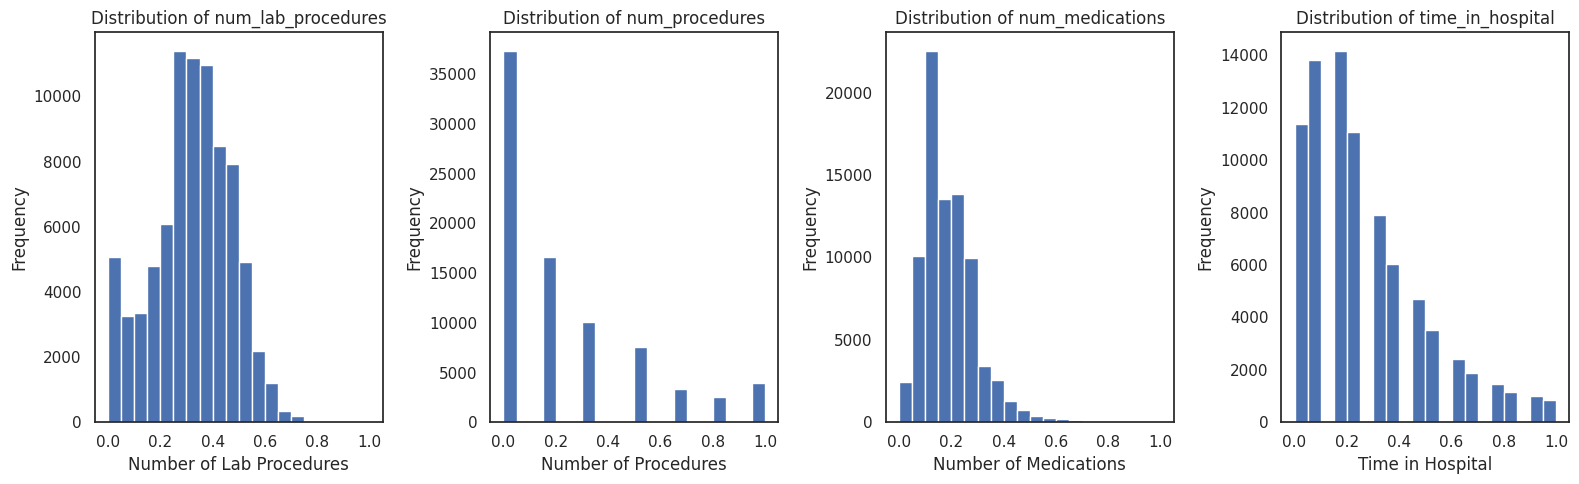

In [ ]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 4, 1)
plt.hist(X_train['num_lab_procedures'], bins=20)
plt.title('Distribution of num_lab_procedures')
plt.xlabel('Number of Lab Procedures')
plt.ylabel('Frequency')

plt.subplot(1, 4, 2)
plt.hist(X_train['num_procedures'], bins=20)
plt.title('Distribution of num_procedures')
plt.xlabel('Number of Procedures')
plt.ylabel('Frequency')

plt.subplot(1, 4, 3)
plt.hist(X_train['num_medications'], bins=20)
plt.title('Distribution of num_medications')
plt.xlabel('Number of Medications')
plt.ylabel('Frequency')

plt.subplot(1, 4, 4)
plt.hist(X_train['time_in_hospital'], bins=20)
plt.title('Distribution of time_in_hospital')
plt.xlabel('Time in Hospital')
plt.ylabel('Frequency')


plt.tight_layout()
plt.show()

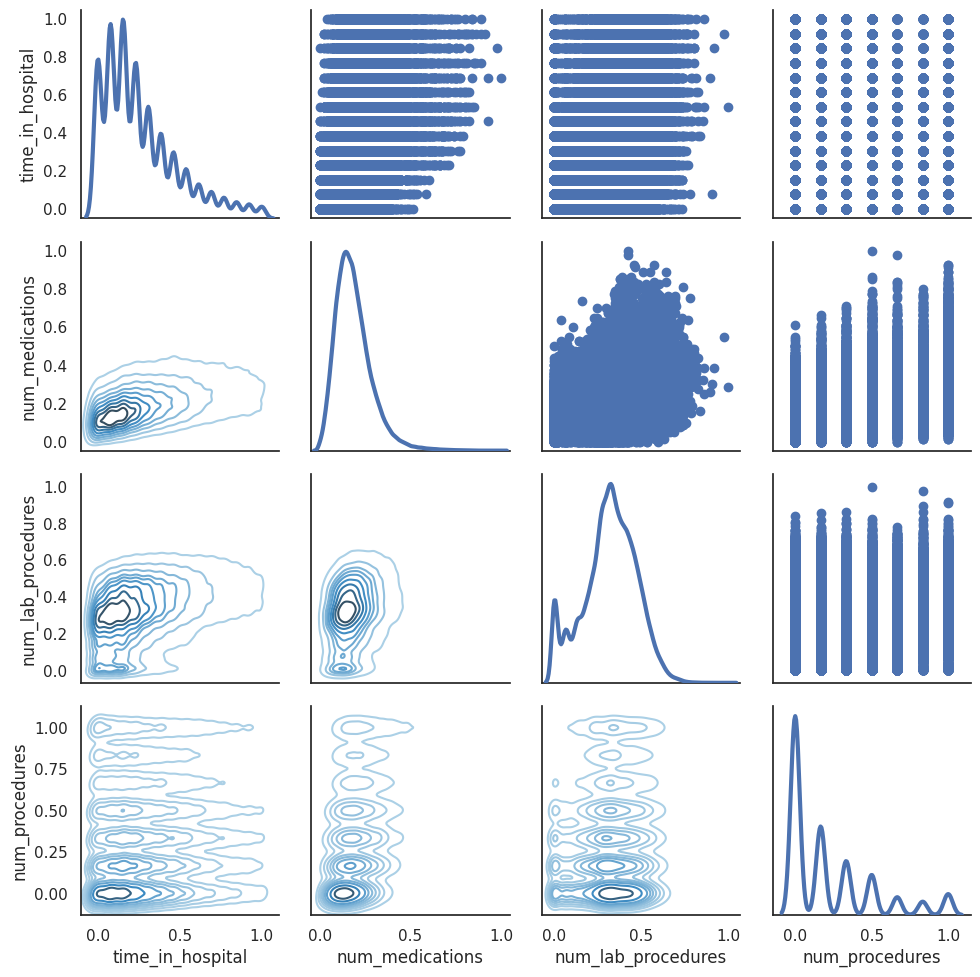

In [ ]:
sns.set(style="white")
df = X_train.loc[:,['time_in_hospital', 'num_medications', 'num_lab_procedures', 'num_procedures',]]
g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

In [ ]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=123)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

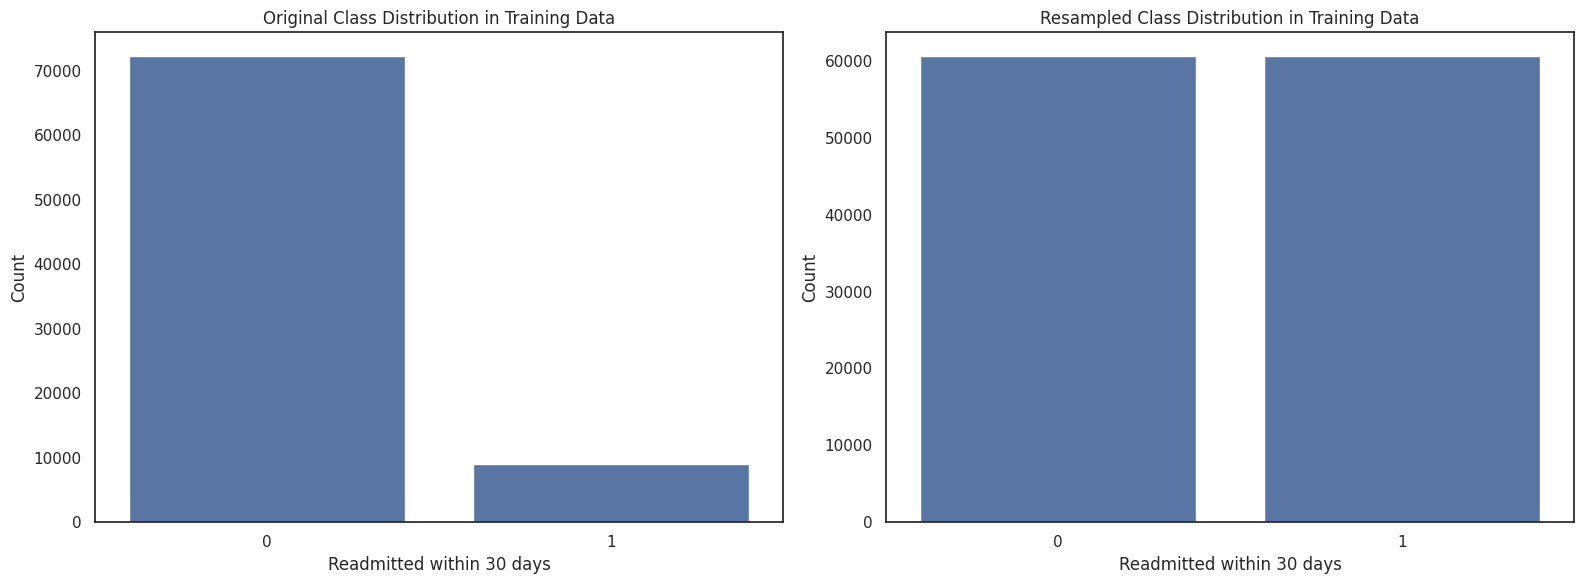

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title('Original Class Distribution in Training Data')
axes[0].set_xlabel('Readmitted within 30 days')
axes[0].set_ylabel('Count')

sns.countplot(x=y_resampled, ax=axes[1])
axes[1].set_title('Resampled Class Distribution in Training Data')
axes[1].set_xlabel('Readmitted within 30 days')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
wandb.init(project='rehospitalization', name='logreg_run')

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_resampled, y_resampled)

y_pred = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

wandb.log({
    'accuracy': accuracy,
    'recall': recall,
    'f1_score': f1
})
wandb.finish()

accuracy,▁
f1_score,▁
recall,▁
accuracy,0.51528
f1_score,0.19632
recall,0.52735


In [ ]:
wandb.init(project='rehospitalization', name='dt_classifier_run')

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_resampled, y_resampled)

y_pred_dt = dt_classifier.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1 = f1_score(y_test, y_pred_dt)

wandb.log({
    'accuracy': accuracy,
    'recall': recall,
    'f1_score': f1
})
wandb.finish()

accuracy,▁
f1_score,▁
recall,▁
accuracy,0.51528
f1_score,0.15089
recall,0.52735


In [ ]:
wandb.init(project='rehospitalization', name='ada')

ada_classifier = AdaBoostClassifier(random_state=42, n_estimators=50)
ada_classifier.fit(X_resampled, y_resampled)
y_pred_ada = ada_classifier.predict(X_test)

accuracy_ada = accuracy_score(y_test, y_pred_ada)
recall_ada = recall_score(y_test, y_pred_ada)

wandb.log({
    'accuracy_ada': accuracy_ada,
    'recall_ada': recall_ada
})

wandb.finish()

accuracy_ada,▁
recall_ada,▁
accuracy_ada,0.84033
recall_ada,0.16674


In [ ]:
wandb.init(project='rehospitalization', name='bagging-100')

bagging_classifier = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=100, random_state=42)
bagging_classifier.fit(X_resampled, y_resampled)
y_pred_bagging = bagging_classifier.predict(X_test)

accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
recall_bagging = recall_score(y_test, y_pred_bagging)

wandb.log({
    'accuracy_bagging': accuracy_bagging,
    'recall_bagging': recall_bagging
})

wandb.finish()

accuracy_bagging,▁
recall_bagging,▁
accuracy_bagging,0.88528
recall_bagging,0.02057


In [ ]:
wandb.init(project='rehospitalization', name='xgboost_classifier_run')

scale_pos_weight = len(y_train) / sum(y_train == 1)

xgb_classifier = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=4,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
xgb_classifier.fit(X_resampled, y_resampled)

y_pred = xgb_classifier.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred)
recall_xgb = recall_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred)

wandb.log({
    'accuracy_xgb': accuracy_xgb,
    'recall_xgb': recall_xgb,
    'f1_xgb': f1_xgb
})

wandb.finish()

accuracy_xgb,▁
f1_xgb,▁
recall_xgb,▁
accuracy_xgb,0.54166
f1_xgb,0.25671
recall_xgb,0.70503


In [ ]:
wandb.init(project='rehospitalization', name='bagging-dt-logreg-svc', config={
    'model': 'VotingClassifier',
    'base_models': ['DecisionTree', 'LogisticRegression', 'SVC'],
    'voting': 'hard'
})

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

model1 = DecisionTreeClassifier(random_state=42)
model2 = LogisticRegression(random_state=42)
model3 = SVC(random_state=42)

voting_classifier = VotingClassifier(estimators=[
    ('dt', model1),
    ('lr', model2),
    ('svc', model3)
], voting='hard')

voting_classifier.fit(X_resampled, y_resampled)

y_pred_voting = voting_classifier.predict(X_test)
accuracy_voting = accuracy_score(y_test, y_pred_voting)
recall_voting = recall_score(y_test, y_pred_voting)

wandb.log({
    'accuracy_voting': accuracy_voting,
    'recall_voting': recall_voting
})
